In [28]:

from matplotlib import pyplot as plt
from numpy import arange
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, accuracy_score
from torch import zeros
from tqdm.auto import tqdm
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, k_fold_cross_validator
from models.rocket import ROCKET
from processor.processor import Leif
from train import train_eval_rocket_segment
from utils.const import SEED
from utils.metric import patient_soft_accuracy
from utils.misc import set_random_state
from utils.path import config_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Rocket parameters
NUM_KERNELS = 1000
NORMALIZE = True

# Classifier parameters
REG_FACTOR = 1e5

# Number of folds in cross validation
K = 5

## Initialize Datasets and Dataloaders

In [2]:
with open(f'{config_path}/leif.yaml', 'r') as reader:
    config = load_yaml(reader, Loader=FullLoader)

# Configure processor
processor = Leif(config)

# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True)
test_ds = KIDataset(data_processor=processor, train=False)

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-dataset-train
loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-dataset-test


In [3]:
scores, accuracies, predictions = zeros(K), zeros(K), []
for i, (train_ds, val_ds) in tqdm(enumerate(k_fold_cross_validator(train_val_ds, k=K)), unit='fold', total=K):
    set_random_state(SEED)

    pred, val_batch = train_eval_rocket_segment(train_ds, val_ds,
                                                rocket=ROCKET(c_in=train_ds.x.shape[1],
                                                              seq_len=train_ds.x.shape[2],
                                                              n_kernels=NUM_KERNELS,
                                                              normalize=NORMALIZE),
                                                clf=RidgeClassifier(alpha=REG_FACTOR, random_state=SEED))

    # Compute F1 Score
    scores[i] = f1_score(val_batch.y.numpy(), pred, average='macro')
    accuracies[i] = accuracy_score(val_batch.y.numpy(), pred)
    predictions.append((pred, val_batch))

# Print average fold score
print(f'average fold f1 score: {scores.mean()}')
# Print score for each fold
print('\n'.join([f'fold {i}: {score}' for i, score in enumerate(scores)]))
# Print average fold accuracy
print(f'average fold accuracy: {accuracies.mean():.2%}')
# Print accuracy for each fold
print('\n'.join([f'fold {i}: {accuracy:.2%}' for i, accuracy in enumerate(accuracies)]))

  0%|          | 0/5 [00:00<?, ?fold/s]

average fold f1 score: 0.6476844549179077
fold 0: 0.6242900490760803
fold 1: 0.674968421459198
fold 2: 0.6512922048568726
fold 3: 0.6331955194473267
fold 4: 0.6546762585639954
average fold accuracy: 64.00%
fold 0: 61.48%
fold 1: 66.97%
fold 2: 64.28%
fold 3: 62.46%
fold 4: 64.83%


### Use segment predictions to predict trial

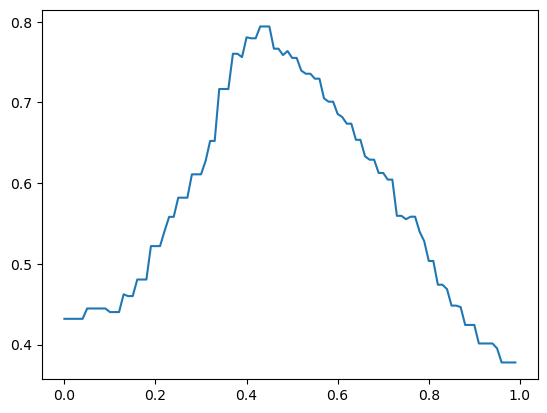

In [35]:
thresholds = arange(0, 1, 0.01)
threshold_scores = zeros(len(thresholds))
for i, th in enumerate(thresholds):
    trial_scores, trial_accuracies = zeros(K), zeros(K)
    for j, (pred, batch) in enumerate(predictions):
        trial_pred, trial_label, trial_accuracy = patient_soft_accuracy(segment_scores=pred, y=batch.y, z=batch.z,
                                                                        threshold=th)

        # Compute F1 Score
        trial_scores[j] = f1_score(trial_label, trial_pred, average='macro')
        trial_accuracies[j] = accuracy_score(trial_label, trial_pred)

    threshold_scores[i] = trial_scores.mean()
    continue

    # Print average fold trial score
    print(f'average fold f1 trial score: {trial_scores.mean()}')
    # Print trial_score for each fold
    print('\n'.join([f'fold {i}: {trial_score}' for i, trial_score in enumerate(trial_scores)]))
    # Print average fold trial accuracy
    print(f'average fold trial accuracy: {trial_accuracies.mean():.2%}')
    # Print trial_accuracy for each fold
    print('\n'.join([f'fold {i}: {trial_accuracy:.2%}' for i, trial_accuracy in enumerate(trial_accuracies)]))

plt.plot(thresholds, threshold_scores)
plt.show()

In [36]:
from numpy import argmax

print(thresholds[argmax(threshold_scores)])

0.43
